<a href="https://colab.research.google.com/github/Nov05/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [117]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [118]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [119]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=277.57448538980236, mobile=True), User(purchased=False, time_on_site=526.6804473696257, mobile=False), User(purchased=False, time_on_site=283.4113677545827, mobile=True), User(purchased=False, time_on_site=285.1361523652161, mobile=False), User(purchased=False, time_on_site=255.77182967807354, mobile=True), User(purchased=False, time_on_site=222.65191896098085, mobile=True), User(purchased=False, time_on_site=138.64245314185467, mobile=True), User(purchased=False, time_on_site=71.55481160733176, mobile=True), User(purchased=False, time_on_site=95.03680325379752, mobile=True), User(purchased=False, time_on_site=214.50816074222482, mobile=True)]


In [120]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,277.574485,True
1,False,526.680447,False
2,False,283.411368,True
3,False,285.136152,False
4,False,255.771830,True


In [121]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.337274184994879,5.350946093942092,5.967750641292825,7.521318527898329,7.571621699439511,8.082194392019566,8.108727191177202,9.065769055744568,9.885023078140028,9.978206875691798,10.437245953456305,10.752901608799716,10.851723745890173,10.972099841668117,11.214521860577756,11.670040259231026,11.765384168953725,11.823345499215915,11.843891720354165,12.274698294174986,12.680554103182844,13.152191486715319,13.686355250457652,13.693396786551633,13.813795349115951,13.943296906079777,13.948623887132515,14.048266876842465,14.218675686903234,14.773178992697144,15.133316475232823,15.170173314103677,15.345394156986567,16.04064503250232,16.38118800682394,16.40282199681161,16.467782463961377,16.47815812881472,17.02197058330036,17.19675604717064,...,508.69164448000186,515.5553217364053,517.9515090119927,520.5557285451962,521.5582123607762,526.6804473696257,526.8245280326604,528.6269498773122,529.0223794735099,530.7073859062464,531.1883608376215,532.4596270022287,536.6275493833658,537.0893334406517,537.4162533705447,540.7599715999154,541.3123804320679,545.3556914372105,551.6743264332373,552.7830567977535,553.9772271050323,560.3470305937986,567.9149400535468,570.112729779641,570.9310255417319,571.1693473695527,576.6325164210076,577.4781223569067,578.1946551229481,579.8689379218109,581.7921805232245,583.8061951796467,583.9972457391868,584.4009458714976,586.591102466188,590.8267913462354,593.4461051445081,594.1095623846385,595.8247275806912,599.4535650766437
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,...,1,1,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,0,0,1,0,1
True,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0


In [122]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

# might have errors here. "TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'"
# if so, downgrad pandas from version 0.24.0 to 0.23.4 
# https://lambdaschoolstudents.slack.com/archives/GGUTEGALS/p1559151252042400

time_on_site,"(4.743, 124.161]","(124.161, 242.984]","(242.984, 361.807]","(361.807, 480.63]","(480.63, 599.454]"
purchased,,,,,
False,252,209,117,33,31
True,95,151,69,25,18


In [123]:
pd.__version__

'0.23.4'

In [124]:
!pip install pandas==0.23.4

In [125]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns') # normalize : boolean, {‘all’, ‘index’, ‘columns’}, or {0,1}, default False

time_on_site,"(4.743, 124.161]","(124.161, 242.984]","(242.984, 361.807]","(361.807, 480.63]","(480.63, 599.454]"
purchased,,,,,
False,0.726225,0.580556,0.629032,0.568966,0.632653
True,0.273775,0.419444,0.370968,0.431034,0.367347


In [126]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.732,0.612
True,0.268,0.388


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [129]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [130]:
!ls 'drive/My Drive/'

'Colab Notebooks'  'Lambda School'


In [0]:
file_path = "drive/My Drive/Lambda School/DS-Unit-1-Sprint-1-Dealing-With-Data-master/module3-databackedassertions/persons.csv"
my_data = pd.read_csv(file_path)

In [132]:
my_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
my_data = my_data.drop('Unnamed: 0', axis=1)

In [134]:
my_data.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [135]:
my_data.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [136]:
my_data.isnull().sum()

age              0
weight           0
exercise_time    0
dtype: int64

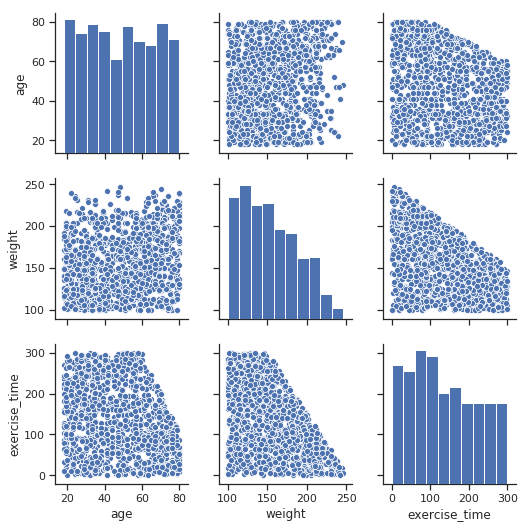

In [137]:
# pd.plotting.scatter_matrix(my_data, figsize=[10,10]);
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.pairplot(my_data, );

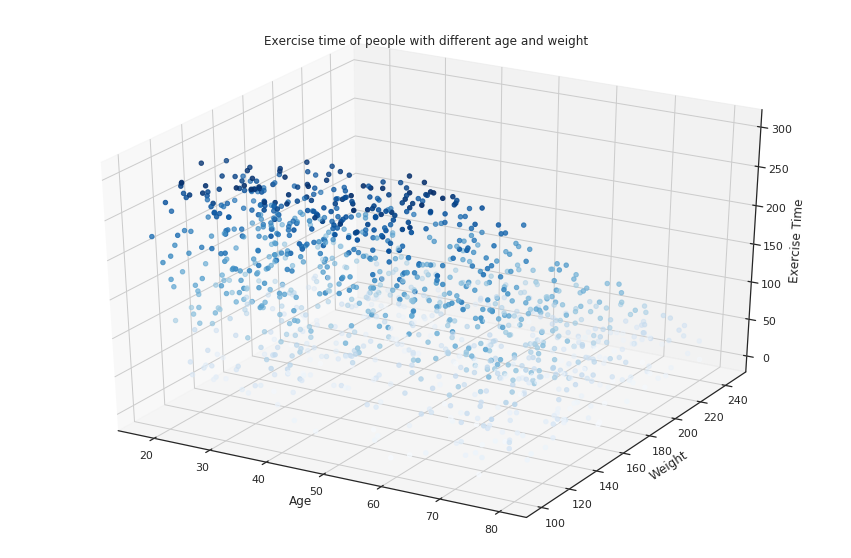

In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

ax.scatter(my_data.age, my_data.weight, my_data.exercise_time, c=my_data.exercise_time, cmap='Blues')
ax.set_title('Exercise time of people with different age and weight')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time');

plt.show()

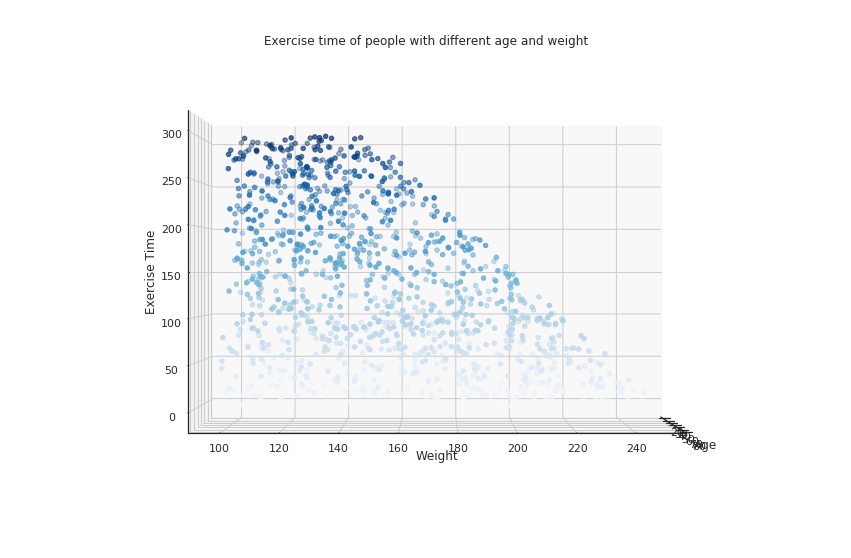

In [139]:
# Exercise time of people with different weight
# The points on the right upper corner are "missing". 
ax.view_init(0, 0)
fig

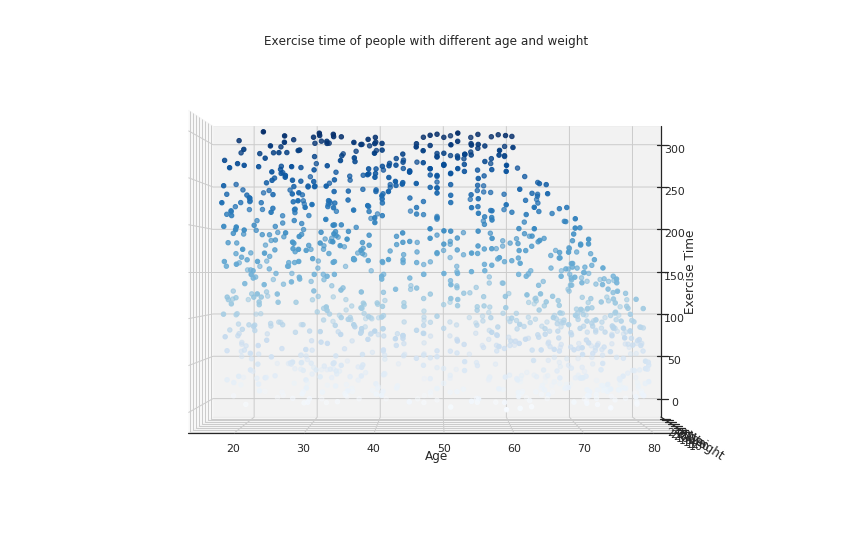

In [140]:
# Exercise time for people with different age
# The points on the right upper corner are "missing".
ax.view_init(0, 270)
fig

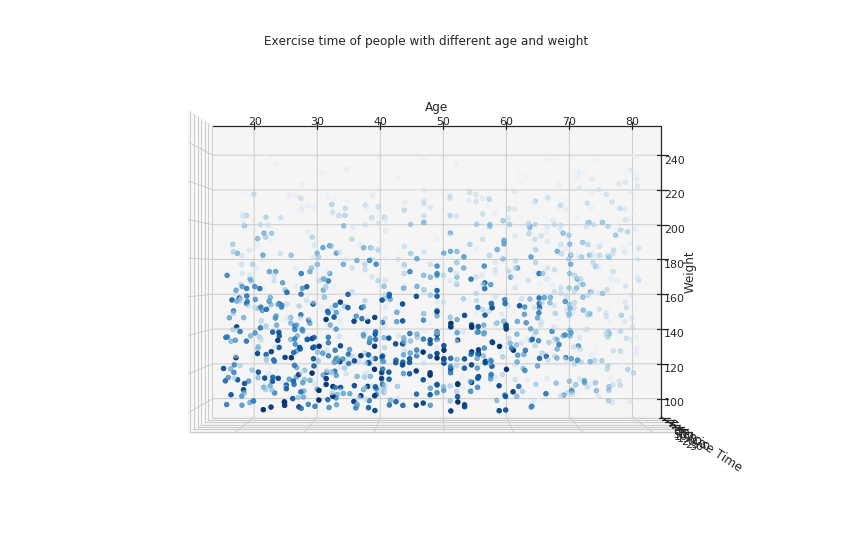

In [141]:
# Exercise time of people with different age and weight
ax.view_init(90, 270)
fig

In [0]:
bin_number = 5

In [0]:
age_bins, age_intervals = pd.cut(my_data['age'], bins=bin_number, precision=0, retbins=True)
weight_bins, weight_intervals = pd.cut(my_data['weight'], bins=bin_number, retbins=True)
time_bins, time_intervals = pd.cut(my_data['exercise_time'], bins=bin_number, retbins=True)

In [189]:
age_intervals

array([17.938, 30.4  , 42.8  , 55.2  , 67.6  , 80.   ])

In [190]:
ct1 = pd.crosstab(age_bins, time_bins, normalize='columns')
ct1

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(18.0, 30.0]",0.187050,0.145570,0.242152,0.317708,0.225131
"(30.0, 43.0]",0.187050,0.174051,0.188341,0.244792,0.298429
"(43.0, 55.0]",0.147482,0.132911,0.174888,0.177083,0.350785
"(55.0, 68.0]",0.165468,0.224684,0.179372,0.213542,0.125654
"(68.0, 80.0]",0.312950,0.322785,0.215247,0.046875,0.000000


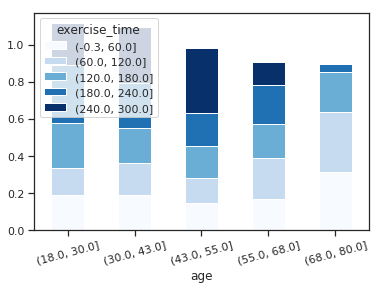

In [191]:
# Exercise time of people with different ages
ct1.plot(kind='bar', stacked=True, colormap='Blues', rot=15);

In [192]:
ct2 = pd.crosstab(weight_bins, time_bins, normalize='columns')
ct2

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",0.190647,0.205696,0.318386,0.411458,0.560209
"(129.2, 158.4]",0.158273,0.240506,0.300448,0.385417,0.387435
"(158.4, 187.6]",0.219424,0.294304,0.251121,0.197917,0.052356
"(187.6, 216.8]",0.273381,0.231013,0.130045,0.005208,0.000000
"(216.8, 246.0]",0.158273,0.028481,0.000000,0.000000,0.000000


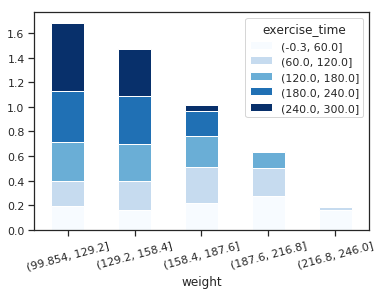

In [193]:
# exercise_time of people with different weight
ct2.plot(kind='bar', stacked=True, colormap='Blues', rot=15);

In [194]:
ct3 = pd.crosstab(age_bins, weight_bins, normalize='columns')
ct3

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(18.0, 30.0]",0.213333,0.256716,0.189922,0.189944,0.132075
"(30.0, 43.0]",0.277333,0.185075,0.189922,0.173184,0.132075
"(43.0, 55.0]",0.208000,0.185075,0.189922,0.145251,0.150943
"(55.0, 68.0]",0.141333,0.211940,0.174419,0.245810,0.169811
"(68.0, 80.0]",0.160000,0.161194,0.255814,0.245810,0.415094


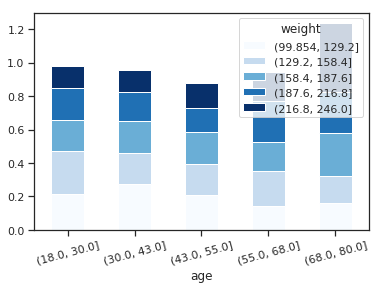

In [195]:
# weight vs. age of people
ct3.plot(kind='bar', stacked=True, colormap='Blues', rot=15);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. all are int64.
2. Exercise time seems to correlated to both age and weight; age and weight seem to correlated too.
3. Exercise time and age, exercise time and weight, seem "real"; age and weight spurious. But since **there are much less data for people with both older age and heavier weight**, It is hard to tell "Exercise time" and "Age and weight" are correlated.

In [197]:
# 3D cross table
ct4 = pd.crosstab(time_bins, [age_bins, weight_bins], 
                 normalize='columns')
ct4

age               (18.0, 30.0]      ...         (68.0, 80.0]
weight         (99.854, 129.2]      ...       (216.8, 246.0]
exercise_time                       ...                     
(-0.3, 60.0]            0.1250      ...             0.681818
(60.0, 120.0]           0.1125      ...             0.318182
(120.0, 180.0]          0.2125      ...             0.000000
(180.0, 240.0]          0.2375      ...             0.000000
(240.0, 300.0]          0.3125      ...             0.000000

[5 rows x 25 columns]

In [198]:
ct4.shape

(5, 25)

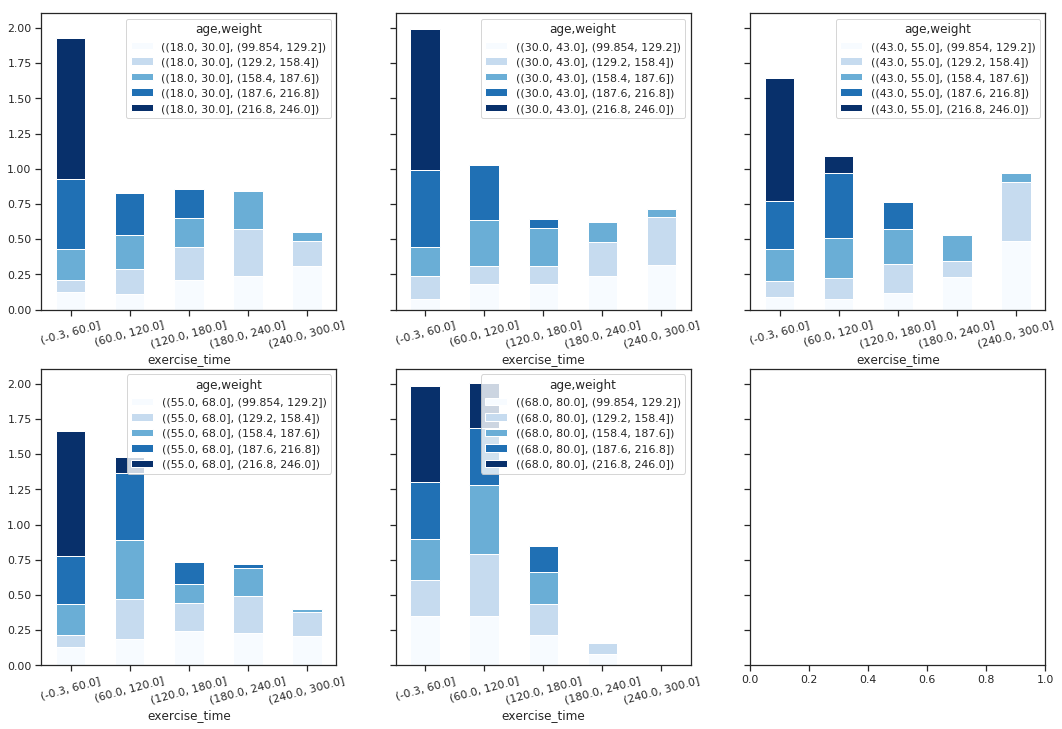

In [211]:
fig, axes = plt.subplots(nrows=2, ncols=3, 
                         sharey=True, figsize=(18, 12))
for row in range(2):
  for col in range(3):
    if (row != 1 or col != 2):
      idx = row * 3 + col
      ct = ct4.iloc[:, idx*bin_number:(idx+1)*bin_number]
      ct.plot(ax=axes[row, col], kind='bar', stacked=True, colormap='Blues', rot=15);
      for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(15)

In [0]:
# 3D cross table
ct5 = pd.crosstab(time_bins, [weight_bins, age_bins], 
                 normalize='columns')

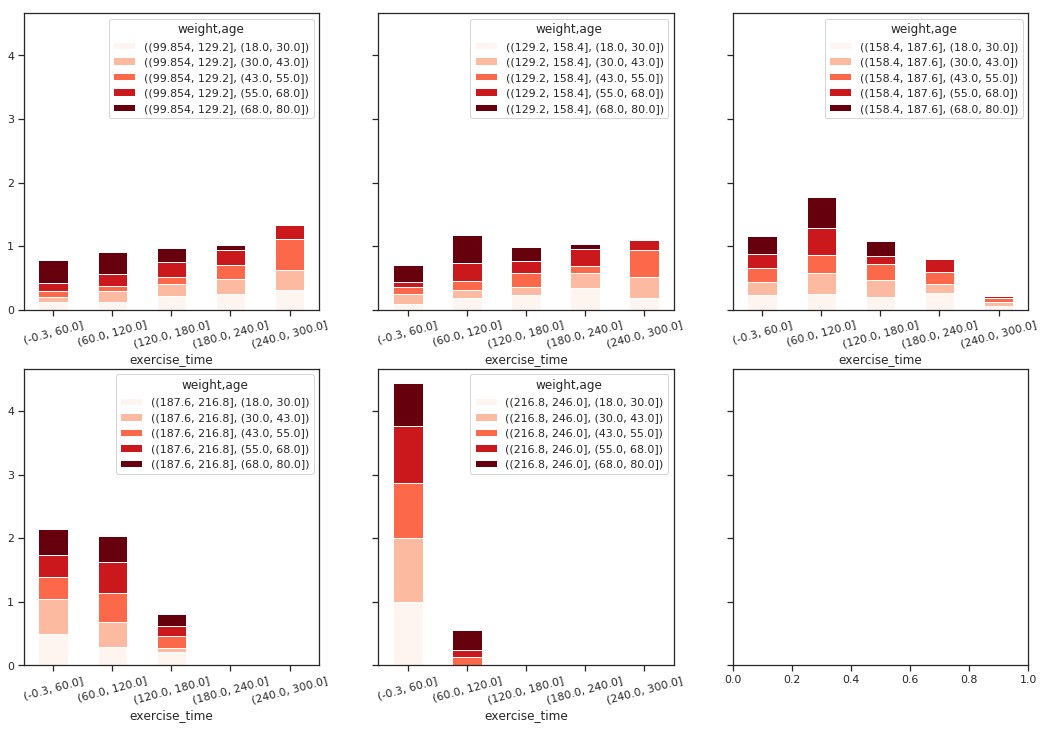

In [215]:
fig, axes = plt.subplots(nrows=2, ncols=3, 
                         sharey=True, figsize=(18, 12))
for row in range(2):
  for col in range(3):
    if (row != 1 or col != 2):
      idx = row * 3 + col
      ct = ct5.iloc[:, idx*bin_number:(idx+1)*bin_number]
      ct.plot(ax=axes[row, col], kind='bar', stacked=True, colormap='Reds', rot=15);
      for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(15)

In [152]:
# 3D bar plot, give up for now
import numpy as np 

width = age_intervals[1] - age_intervals[0]
depth = weight_intervals[1] - weight_intervals[0]
# top = mean exercise time of certain age bin and weight bin
top = np.random.randint(5, size=25)
bottom = np.zeros_like(top)
print(width, depth, height)
print(top)

12.462 29.34599999999999 0
[1 2 2 2 3 2 2 0 4 4 3 3 1 4 3 1 1 1 1 4 4 3 0 0 2]


In [0]:
# 3D bar plot
# https://matplotlib.org/3.1.0/gallery/mplot3d/3d_bars.html
  
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

ax.bar3d(my_data.age, my_data.weight,
         bottom, width, depth, top,
         shade=True
        )
ax.set_title('Exercise time for people with different age and weight')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time');

plt.show()

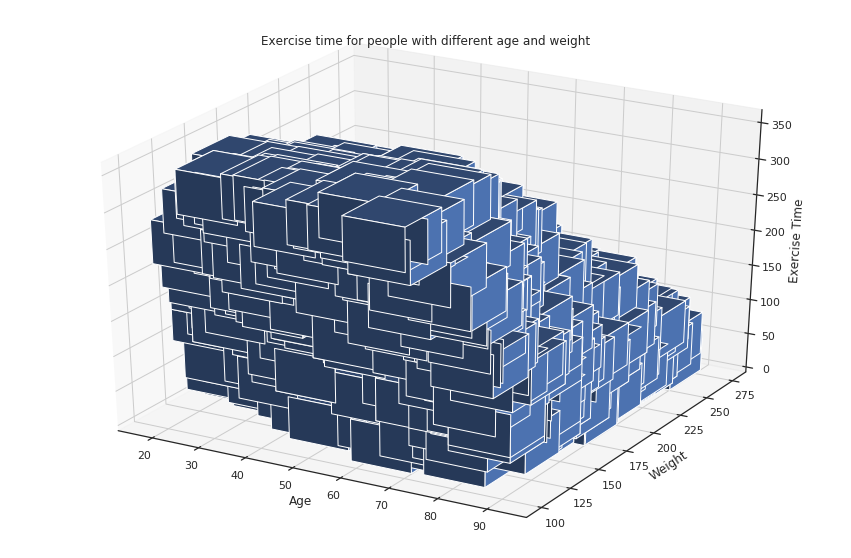

In [212]:
# Oops! I don't know what it is. But it looks pretty. So I am gonna keep it.
# 3D bar plot

d_age = age_intervals[1] - age_intervals[0]
d_weight = weight_intervals[1] - weight_intervals[0]
d_time = time_intervals[1] - time_intervals[0]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

ax.bar3d(my_data.age, my_data.weight, my_data.exercise_time, 
         d_age, d_weight, d_time,
         shade=True
#          c=my_data.exercise_time,
#          cmap='Blues'
        )
ax.set_title('Exercise time for people with different age and weight')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time');

plt.show()

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [0]:
# A Confounder is a variable whose presence affects the variables 
# being studied sothat the results do not reflect the actual relationship. 
# There are various ways to exclude or control confounding variables 
# including Randomization, Restriction and Matching. But all these 
# methods are applicable at the time of study design. When experimental 
# designs are premature, impractical, or impossible, researchers must 
# rely on statistical methods to adjust for potentially confounding 
# effects. These Statistical models (especially regression models) 
# are flexible to eliminate the effects of confounders.